In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline

C:\Users\NINAD VAIDYA\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# A function to load the input images and set its dimensions to 1024 x 768
def load_image(image_path):
    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)# decodes the image into a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]# broadcasting the image array so that it has a batch dimension

    return img

In [3]:
def imshow(image, title=None):
    if(len(image.shape) > 3):# suppose dim is like 1,2,4,2,2,1... it removes the ones so that only 3 values remain W,H,c
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):# if there's a title mention it
        plt.title(title)

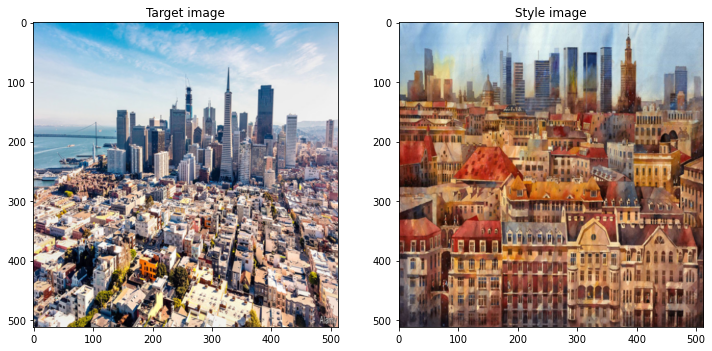

In [4]:
# Let's see the images
#There are two images a content image and a style image
content_img=load_image("input.png")
style_img=load_image("style.png")

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Target image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')


In [5]:
print(content_img.shape)
print(style_img.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [6]:
# Defining the content image representation and load the model
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)# preprocessing for the model to be initialized
x=tf.image.resize(x, (256,256))# the vgg19 model takes images in 256
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [7]:
# Chooosing the content and style layers
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [8]:
# Building the model
def my_model(layer_names):
    # Retrieve the output layers corresponding to the content and style layers
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

In [9]:
style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img*255)

In [10]:
# Compute the gram matrix
# Einsum allows defining Tensors by defining their element-wise computation.
# This computation is defined by equation, a shorthand form based on Einstein summation.
def gram_matrix(input_tensor): # input_tensor is of shape ch, n_H, n_W
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # Unrolls n_H and n_W
    return result/(num_locations)

In [11]:
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False
        
    def call(self, inputs):
        inputs=inputs*255.0 # Scale back the pixel values
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)# Pass the preprocessed input to my_model
        
        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output. This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
        # Returns a dict of dicts with content and style representations, i.e., gram matrix of the style_layers and
        # the content of the content_layers

In [12]:
# Now we extract the style and content features by calling the above class
extractor=entire_model(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

results = extractor(tf.constant(content_img))

In [13]:
style_weight=40
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.2,
                 'block2_conv1': 0.19,
                 'block3_conv1': 0.24,
                 'block4_conv1': 0.11,
                 'block5_conv1': 0.26}
# style_weights = {'block1_conv1': 0.3,
#                  'block2_conv1': 0.45,
#                  'block3_conv1': 0.15,
#                  'block4_conv1': 0.05,
#                  'block5_conv1': 0.05}

In [14]:
def total_cost(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)# Normalize

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [15]:
# Define a tf.Variable to contain the image to optimize
generate_image = tf.Variable(content_img)
# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
num_iterations=1500
for i in range(num_iterations):
    if(i%300==0):
        plt.figure(figsize=(12,12))
        plt.subplot(1, 2, 1)
        imshow(np.squeeze(generate_image.read_value(), 0), f'Step {i}')
        plt.subplot(1, 2, 2)
        imshow(style_img, 'Style Image')
    train_step(generate_image)

In [ ]:
train_step(generate_image)
plt.imshow(np.squeeze(generate_image.read_value(), 0))
plt.axis('off')
fig1 = plt.gcf()
fig1.savefig('new_image.png', bbox_inches='tight')